In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
import numpy as np
x_valid = np.load('/content/drive/MyDrive/VSAT_HW1/x_valid.npy')
x_train = np.load('/content/drive/MyDrive/VSAT_HW1/x_train.npy')
y_train=np.load('/content/drive/MyDrive/VSAT_HW1/y_train.npy')
y_valid=np.load('/content/drive/MyDrive/VSAT_HW1/y_valid.npy')

In [ ]:
def convert_CHW(data):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  tmp=[]
  for i,img in enumerate(data,0):
    image=np.array(transform(img).tolist())
    tmp.append(image)
  tmp=np.array(tmp)
  return tmp

In [ ]:
#transform
x_train=convert_CHW(x_train)
x_valid=convert_CHW(x_valid)

In [ ]:
import torch 
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):
    def __init__(self,data,label,transform):
        self.data = torch.FloatTensor(data)
        self.label = torch.LongTensor(label)
        self.transform = transform

    def __getitem__(self,index):
        if self.transform:
            self.data[index] = self.data[index]
        return self.data[index],self.label[index]

    def __len__(self):
        return len(self.data)

In [ ]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


In [ ]:
#dataset
trainset=MyDataset(data=x_train,label=y_train,transform=None)
testset=MyDataset(data=x_valid,label=y_valid,transform=None)
#dataLoader
trainLoader = DataLoader(dataset=trainset,batch_size=8,shuffle=True,num_workers=2)
testLoader = DataLoader(dataset=testset,batch_size=1,num_workers=2)

In [ ]:
# Model structure
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Parameters
criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 8
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [ ]:
def cal_accuracy(net,Loader):
  correct = 0
  total = 0
  loss=0
  running_loss,times=0,0
  with torch.no_grad():
      for data in Loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          values, predicted = outputs.topk(3, dim=1, largest=True, sorted=True)
          total += labels.size(0)
          for i,data in enumerate(labels,0):
            if data in predicted[i]:
              correct+=1
          running_loss+=loss.item()
          times+=1
  return correct/total*100,running_loss/(times)

In [ ]:
# Train
train_loss_value=[]
valid_loss_value=[]
now_epoch=0
for epoch in range(epochs):
    running_loss = 0.0
    for times, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    now_valid_accuracy,now_valid_loss=cal_accuracy(net,testLoader)
    tmp,now_train_loss=cal_accuracy(net,trainLoader)
    print('[%d/%d, %d] train loss: %.3f validation loss: %.3f validation accuracy: %.1f' % (epoch+1, epochs, len(trainLoader), now_train_loss,now_valid_loss,now_valid_accuracy))
    train_loss_value.append(running_loss/(times+1))
    valid_loss_value.append(now_valid_loss)
    
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1/8, 100/5000] loss: 0.115
[1/8, 200/5000] loss: 0.230
[1/8, 300/5000] loss: 0.345
[1/8, 400/5000] loss: 0.460
[1/8, 500/5000] loss: 0.575
[1/8, 600/5000] loss: 0.690
[1/8, 700/5000] loss: 0.804
[1/8, 800/5000] loss: 0.918
[1/8, 900/5000] loss: 1.031
[1/8, 1000/5000] loss: 1.142
[1/8, 1100/5000] loss: 1.253
[1/8, 1200/5000] loss: 1.363
[1/8, 1300/5000] loss: 1.472
[1/8, 1400/5000] loss: 1.579
[1/8, 1500/5000] loss: 1.685
[1/8, 1600/5000] loss: 1.790
[1/8, 1700/5000] loss: 1.895
[1/8, 1800/5000] loss: 1.998
[1/8, 1900/5000] loss: 2.101
[1/8, 2000/5000] loss: 2.201
[1/8, 2100/5000] loss: 2.301
[1/8, 2200/5000] loss: 2.401
[1/8, 2300/5000] loss: 2.497
[1/8, 2400/5000] loss: 2.596
[1/8, 2500/5000] loss: 2.690
[1/8, 2600/5000] loss: 2.786
[1/8, 2700/5000] loss: 2.880
[1/8, 2800/5000] loss: 2.974
[1/8, 2900/5000] loss: 3.071
[1/8, 3000/5000] loss: 3.165
[1/8, 3100/5000] loss: 3.260
[1/8, 3200/5000] loss: 3.352
[1/8, 3300/5000] loss: 3.445
[1/8, 3400/5000] loss: 3.536
[1/8, 3500/5000] loss: 

In [ ]:
# validation accuracy
now_valid_accuracy,now_valid_loss=cal_accuracy(net,testLoader)
print('Accuracy of the network on the 10000 validation inputs: %.2f %%' % (now_valid_accuracy))

Accuracy of the network on the 10000 test inputs: 87.52 %


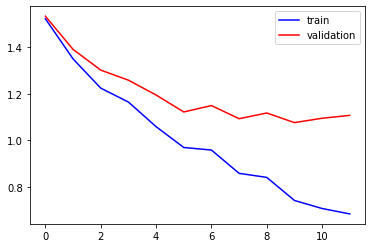

In [ ]:
#loss curve
import matplotlib.pyplot as plt
plt.plot(np.array(train_loss_value), 'blue', label='train')
plt.plot(np.array(valid_loss_value), 'r', label='validation')
plt.legend()
plt.show
plt.savefig('/content/drive/MyDrive/VSAT_HW1/loss.png')

In [ ]:
# Save model
model_name='/content/drive/MyDrive/VSAT_HW1/cnn_model.pth'
torch.save(net,model_name)

In [ ]:
# Load model
net=torch.load('/content/drive/MyDrive/VSAT_HW1/cnn_model.pth')
now_valid_accuracy,now_valid_loss=cal_accuracy(net,testLoader)
print('Accuracy of the network on the 10000 validation inputs: %.2f %%' % (now_valid_accuracy))
print('Top-3 error rate of the network on the 10000 validation inputs: %.2f %%' % (100-now_valid_accuracy))

Accuracy of the network on the 10000 validation inputs: 88.43 %
Top-3 error rate of the network on the 10000 validation inputs: 11.57 %


In [ ]:
# test data
x_test=np.load('/content/drive/MyDrive/VSAT_HW1/x_test.npy')
x_test=convert_CHW(x_test)
testset=MyDataset(data=x_test,label=y_valid,transform=None)
testLoader = DataLoader(dataset=testset,batch_size=1,num_workers=2)

In [ ]:
# output
ans=[]
with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs = net(inputs)
        values, predicted = outputs.topk(3, dim=1, largest=True, sorted=True)
        for i,data in enumerate(predicted,0):
          ans.append(data.tolist())

In [ ]:
# write
txtpath='/content/drive/MyDrive/VSAT_HW1/0712534.txt'
f = open(txtpath, 'w')
for item in ans:
  f.write(str(item)+'\n')
f.close()

In [ ]:
# number of parameters
number_of_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('The number of parameters: %d' %number_of_params)

The number of parameters: 62006
